# Find variables strongly correlated with MAE

This notebook will reproduce the correlation matrices
* Figure 1: Matrix of Spearman’s correlation coefficients for MAE and system features from SR-DF [...]
* Figure S1: Matrix of Kendall’s coefficients for MAE and system features from SR-DF [...]
* Figure S2: The same as in Fig. S1 but for the Pearson’s r correlation coefficient.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from src.labels_paper import labels
import matplotlib.pyplot as plt
import os
from src.consts import DATADIRECTORY, OUTPUTDIRECTORY

In [2]:
def plot_correlation(df, target, correlation_method='kendall', n_variables = 20, translate_columns=True, filename='correlation_matrix'):
    max_proportion_of_nans = 0.2
    columns_to_remove = []
    for col in df.columns:
        prop = np.mean(df[col].isna())
        if prop > max_proportion_of_nans:
            #print(f'Remove column {col} NaN% {prop}')
            columns_to_remove.append(col)
    df_ = df.drop(columns_to_remove, axis=1)

    # Full correlaiton matrix: not required to compute but simple

    df_full = pd.concat([target, df_], axis=1)
    corr_full = df_full.corr(method=correlation_method)
    mae_corr = np.abs(corr_full['MAE (meV)'])
    mae_corr.sort_values(ascending=False, inplace=True)
    
    variables = mae_corr.head(n_variables).index
    df_ = df_full[variables]
    if translate_columns:
        df_.columns = [labels(c) for c in df_.columns]
    corr = df_.corr(method=correlation_method)
    
    #https://stackoverflow.com/questions/73581384/plotting-a-fancy-diagonal-correlation-matrix-with-coefficients-in-upper-triangle
    mask = np.tril(np.ones_like(corr, dtype=bool)) | corr.abs().le(0.1)
    melt = corr.mask(mask).melt(ignore_index=False).reset_index()
    melt["size"] = melt["value"].abs()

    #fig, ax = plt.subplots(figsize=(12, 9.5))
    fig, ax = plt.subplots(figsize=(11, 8.5))

    # normalize colorbar
    cmap = plt.cm.RdBu
    norm = plt.Normalize(-1, 1)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize="x-small")

    # plot lower triangle (scatter plot with normalized hue and square markers)
    sns.scatterplot(ax=ax, data=melt, x="index", y="variable", size="size",
                    hue="value", hue_norm=norm, palette=cmap,
                    style=0, markers=["s"], legend=False)

    # format grid
    xmin, xmax = (-0.5, corr.shape[0] - 0.5)
    ymin, ymax = (-0.5, corr.shape[1] - 0.5)
    ax.vlines(np.arange(xmin, xmax + 1), ymin, ymax, lw=1, color="silver")
    ax.hlines(np.arange(ymin, ymax + 1), xmin, xmax, lw=1, color="silver")
    ax.set(aspect=1, xlim=(xmin, xmax), ylim=(ymax, ymin), xlabel="", ylabel="")
    ax.tick_params(labelbottom=False, labeltop=True)
    plt.xticks(rotation=90)

    # annotate upper triangle
    for y in range(corr.shape[0]):
        for x in range(corr.shape[1]):
            value = corr.mask(mask).to_numpy()[y, x]
            if pd.notna(value):
                plt.text(x, y, f"{value:.2f}", size="x-small",
                         #color=sm.to_rgba(value), weight="bold",
                          ha="center", va="center")
    outputfilename = os.path.join(OUTPUTDIRECTORY, f'{filename}.pdf')
    plt.savefig(outputfilename, bbox_inches='tight')

In [3]:
df = pd.read_csv(os.path.join(DATADIRECTORY, 'implicit_dataset.csv'))
target = pd.read_csv(os.path.join(DATADIRECTORY,'implicit_target_mae.csv'))
df = df._get_numeric_data()

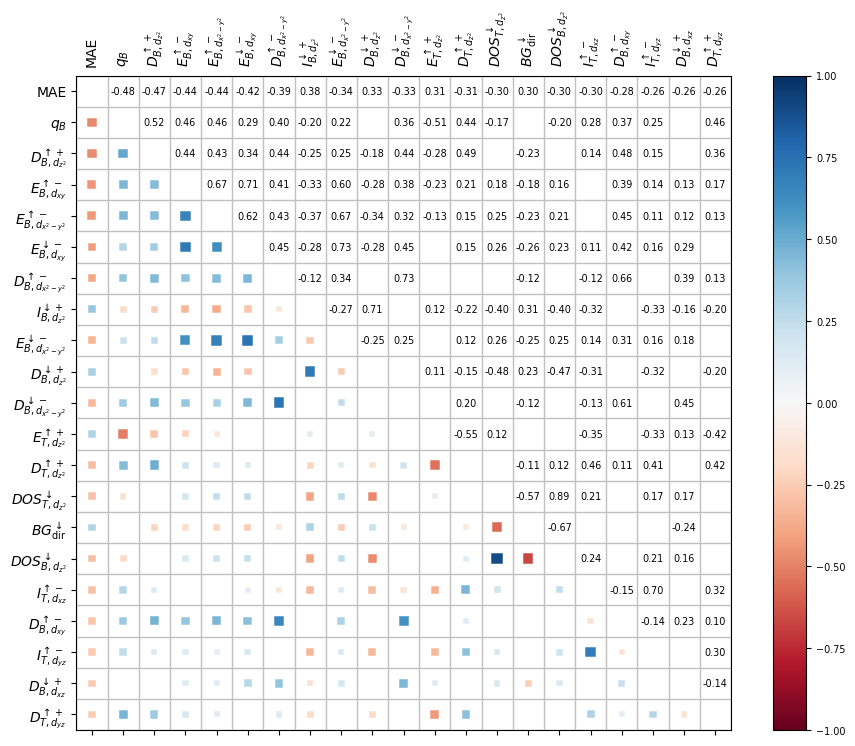

In [4]:
# reproduce Figure 1
plot_correlation(df, target, correlation_method='spearman', n_variables = 21, filename='Figure_1')

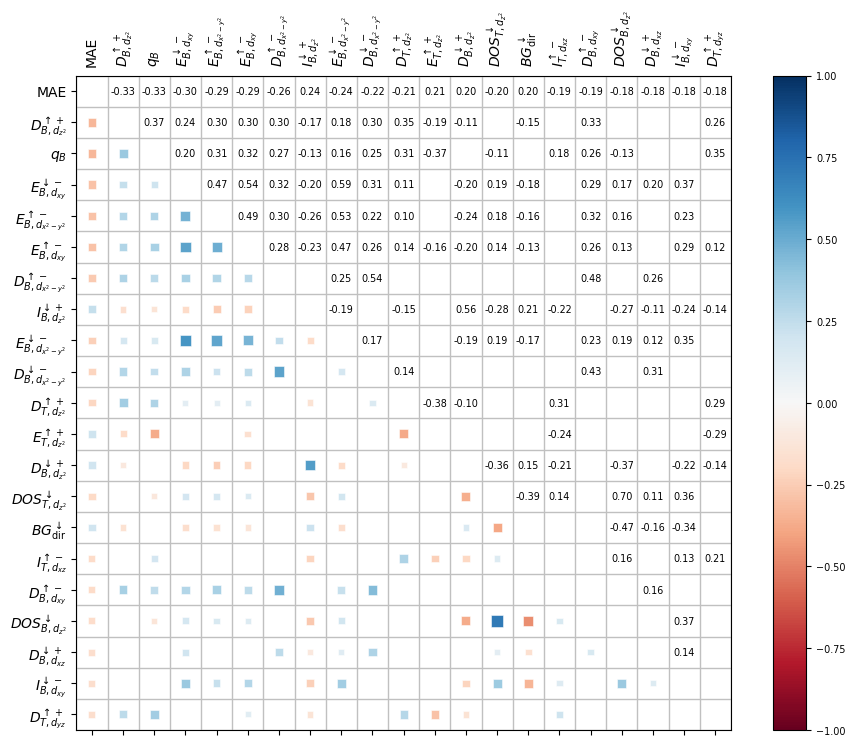

In [5]:
# reproduce Figure S1
plot_correlation(df, target, correlation_method='kendall', n_variables = 21, filename='Figure_S1')

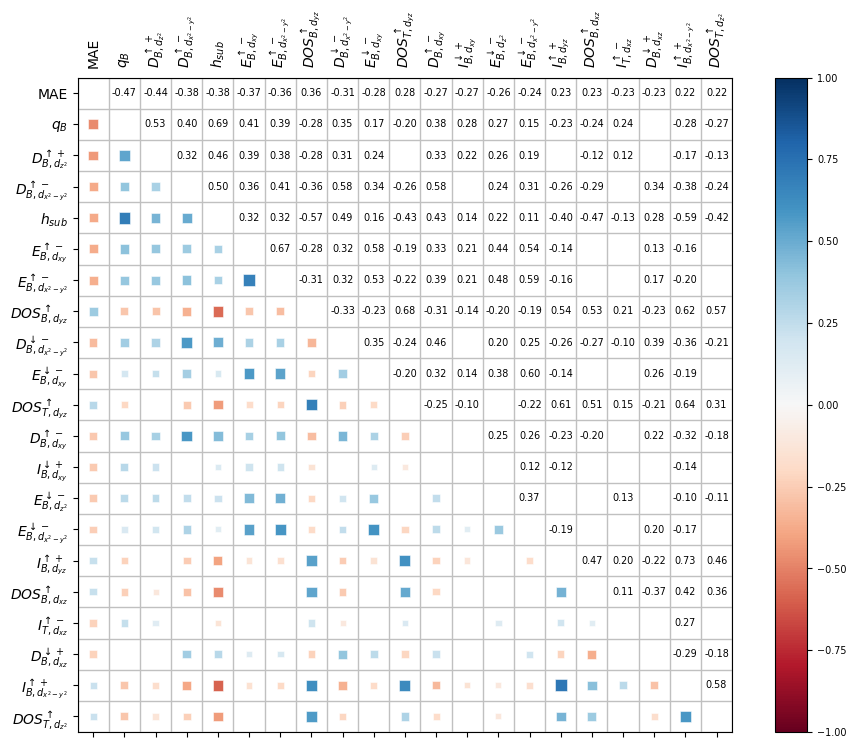

In [6]:
# reproduce Figure S2
plot_correlation(df, target, correlation_method='pearson', n_variables = 21, filename='Figure_S2')